In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from nltk.translate.meteor_score import meteor_score
import nltk
import Levenshtein

In [2]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\seyyedaliayati\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
ALPHA = 0.5

In [4]:
def calculate_levenshtein_accuracy(true_sentence, generated_sentence):
    distance = Levenshtein.distance(true_sentence, generated_sentence)
    max_len = max(len(true_sentence), len(generated_sentence))
    return 1 - (distance / max_len)

# Calculate BLEU (optional alternative)
def calculate_bleu_score(true_sentence, generated_sentence):
    return sentence_bleu([true_sentence.split()], generated_sentence.split())

def calculate_rouge_scores(true_sentence, generated_sentence):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(true_sentence, generated_sentence)
    rouge_scores = {
        "rouge1": scores['rouge1'].fmeasure,
        "rouge2": scores['rouge2'].fmeasure,
        "rougeL": scores['rougeL'].fmeasure
    }
    return list(rouge_scores.values())

def calculate_meteor_score(true_sentence, generated_sentence):
    # Tokenize sentences
    reference_tokens = true_sentence.split()
    generated_tokens = generated_sentence.split()
    # Calculate METEOR score
    return meteor_score([reference_tokens], generated_tokens)

def combined_score(levenshtein_accuracy, bleu_score, alpha=ALPHA):
    return alpha * levenshtein_accuracy + (1 - alpha) * bleu_score

In [5]:
# test rouge
true_sentence = "The quick brown fox jumps over the lazy dog"
generated_sentence = "The quick brown fox jumps over the lazy dog"
rouge_scores = calculate_rouge_scores(true_sentence, generated_sentence)
print(rouge_scores)

[1.0, 1.0, 1.0]


In [6]:
model_map = {
    'base': 'CoAtNet',
    'llama3_2_1b': 'LLAMA-3.2-1B',
    'llama3_2_3b': 'LLAMA-3.2-3B',
    'llama3_1_8b': 'LLAMA-3.1-8B',
    'gpt-4o': 'GPT-4o',
    'echocrypt': 'EchoCrypt',
}

In [7]:
main_dir = '.'

In [8]:
# Data holder for plotting
results = []

for model_dir in os.listdir(main_dir):
    model_path = os.path.join(main_dir, model_dir)
    if os.path.isdir(model_path):
        for csv_file in os.listdir(model_path):
            if csv_file.endswith('.csv'):
                csv_path = os.path.join(model_path, csv_file)
                df = pd.read_csv(csv_path)
                nf = float(csv_file.replace('.csv', ''))
                model_name = model_dir
                # Calculate average accuracy for each CSV (noise factor)
                lev_accuracies = []
                bleu_accuracies = []
                for _, row in df.iterrows():
                    true_sentence = row['True Sentence']
                    predicted_sentence = row['Predicted Sentence']
                    llm_sentence = row['LLM Sentence']
                    
                    base_leven = calculate_levenshtein_accuracy(true_sentence, predicted_sentence)
                    base_bleu = calculate_bleu_score(true_sentence, predicted_sentence)
                    base_combined = combined_score(base_leven, base_bleu)
                    base_meteor = calculate_meteor_score(true_sentence, predicted_sentence)
                    base_rouge1, base_rouge2, base_rougeL = calculate_rouge_scores(true_sentence, predicted_sentence)
                    
                    llm_leven = calculate_levenshtein_accuracy(true_sentence, llm_sentence)
                    llm_bleu = calculate_bleu_score(true_sentence, llm_sentence)
                    llm_combined = combined_score(llm_leven, llm_bleu)
                    llm_meteor = calculate_meteor_score(true_sentence, llm_sentence)
                    llm_rouge1, llm_rouge2, llm_rougeL = calculate_rouge_scores(true_sentence, llm_sentence)
                    
                    results.append({
                        'Model': model_map['base'], # CoAtNet
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': base_leven,
                        'BLEU Accuracy': base_bleu,
                        'Meteor Score': base_meteor,
                        'Rouge-1': base_rouge1,
                        'Rouge-2': base_rouge2,
                        'Rouge-L': base_rougeL,
                        'Adjusted Accuracy': base_combined,
                    })
                    
                    results.append({
                        'Model': model_map[model_name], # LLM
                        'Noise Factor': nf,
                        'Levenshtein Accuracy': llm_leven,
                        'BLEU Accuracy': llm_bleu,
                        'Meteor Score': llm_meteor,
                        'Rouge-1': llm_rouge1,
                        'Rouge-2': llm_rouge2,
                        'Rouge-L': llm_rougeL,
                        'Adjusted Accuracy': llm_combined,
                    })


c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\seyyedaliayati\AppData\Local\anaconda3\envs\rosa\Lib\site-packages\nltk\translate\bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlap

In [9]:
results_df = pd.DataFrame(results)
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,CoAtNet,1.5,0.875000,7.173384e-155,0.404264,0.482759,0.222222,0.482759,0.437500
1,EchoCrypt,1.5,1.000000,1.000000e+00,0.999878,1.000000,1.000000,1.000000,1.000000
2,CoAtNet,1.5,0.892473,1.981705e-01,0.404676,0.444444,0.240000,0.444444,0.545322
3,EchoCrypt,1.5,1.000000,1.000000e+00,0.999818,1.000000,1.000000,1.000000,1.000000
4,CoAtNet,1.5,0.888889,6.848991e-155,0.315625,0.400000,0.111111,0.400000,0.444444
...,...,...,...,...,...,...,...,...,...
29995,LLAMA-3.2-3B,2.0,0.230769,1.119310e-231,0.101010,0.210526,0.000000,0.210526,0.115385
29996,CoAtNet,2.0,0.684932,8.676910e-232,0.103093,0.235294,0.000000,0.235294,0.342466
29997,LLAMA-3.2-3B,2.0,0.571429,4.484824e-78,0.556931,0.571429,0.315789,0.571429,0.285714
29998,CoAtNet,2.0,0.630435,9.853445e-232,0.072464,0.153846,0.000000,0.153846,0.315217


In [10]:

results_df = results_df.groupby(['Model', 'Noise Factor']).mean().reset_index()

In [11]:
# re-order models based on model_map.values()
results_df['Model'] = pd.Categorical(results_df['Model'], model_map.values())

In [12]:
results_df

,Model,Noise Factor,Levenshtein Accuracy,BLEU Accuracy,Meteor Score,Rouge-1,Rouge-2,Rouge-L,Adjusted Accuracy
0,CoAtNet,1.0,0.952524,0.326042,0.632503,0.682050,0.486529,0.682050,0.639283
1,CoAtNet,1.5,0.867842,0.039834,0.317091,0.394319,0.160176,0.394319,0.453838
2,CoAtNet,2.0,0.684093,0.001192,0.079088,0.131215,0.017825,0.131215,0.342642
3,EchoCrypt,1.0,0.992016,0.944155,0.974551,0.975698,0.953258,0.975698,0.968086
4,EchoCrypt,1.5,0.972433,0.882236,0.948465,0.950431,0.911640,0.950356,0.927334
5,EchoCrypt,2.0,0.834485,0.568243,0.772692,0.786364,0.660995,0.784525,0.701364
6,GPT-4o,1.0,0.998468,0.985862,0.993644,0.993923,0.988591,0.993846,0.992165
7,GPT-4o,1.5,0.989780,0.941105,0.974406,0.975622,0.956677,0.975531,0.965443
8,GPT-4o,2.0,0.874738,0.622773,0.806706,0.817414,0.706510,0.816342,0.748755
9,LLAMA-3.1-8B,1.0,0.989622,0.944703,0.980652,0.981767,0.963642,0.981439,0.967162


In [13]:
results_df['Noise Factor'] = results_df['Noise Factor'].astype(str)


In [14]:
# Separate data for each plot
def plot_accuracy(df, accuracy_type):
    plt.figure(figsize=(10, 6))
    for model in model_map.values():
        model_data = df[df['Model'] == model]
        plt.plot(model_data['Noise Factor'], model_data[accuracy_type], marker='o', label=model)
        # print model, nf, accuracy_type, accuracy
        print(f"Base Model: Phone, Model: {model}, NF: {model_data['Noise Factor'].values}, {accuracy_type}: {model_data[accuracy_type].values}")

    plt.xlabel('Noise Factor', fontweight='bold')
    plt.ylabel(f'{accuracy_type}', fontweight='bold')
    plt.title(f'Phone Model', fontweight='bold') # (alpha={ALPHA})
    
    # Bold tick numbers
    # plt.xticks(fontweight='bold')
    # plt.yticks(fontweight='bold')
    
    plt.legend()
    plt.savefig(f'{accuracy_type.replace(' ', '_').replace('-', '_')}_phone.pdf', format='pdf')
    plt.show()

Base Model: Phone, Model: CoAtNet, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.32604225 0.03983415 0.00119167]
Base Model: Phone, Model: LLAMA-3.2-1B, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.74007361 0.39138811 0.02301879]
Base Model: Phone, Model: LLAMA-3.2-3B, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.89223488 0.62432033 0.08417464]
Base Model: Phone, Model: LLAMA-3.1-8B, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.94470303 0.77156768 0.15675686]
Base Model: Phone, Model: GPT-4o, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.98586158 0.94110496 0.62277266]
Base Model: Phone, Model: EchoCrypt, NF: ['1.0' '1.5' '2.0'], BLEU Accuracy: [0.94415514 0.88223592 0.56824274]


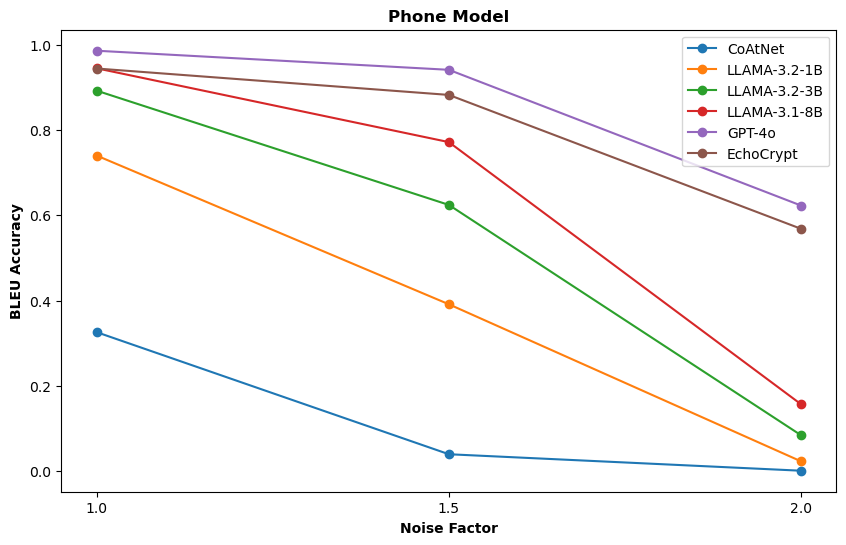

Base Model: Phone, Model: CoAtNet, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.6325028  0.3170911  0.07908767]
Base Model: Phone, Model: LLAMA-3.2-1B, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.8651371  0.6585964  0.17624067]
Base Model: Phone, Model: LLAMA-3.2-3B, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.95658671 0.82869829 0.3643809 ]
Base Model: Phone, Model: LLAMA-3.1-8B, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.98065181 0.90230348 0.46959115]
Base Model: Phone, Model: GPT-4o, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.99364403 0.9744062  0.80670569]
Base Model: Phone, Model: EchoCrypt, NF: ['1.0' '1.5' '2.0'], Meteor Score: [0.97455079 0.94846513 0.7726919 ]


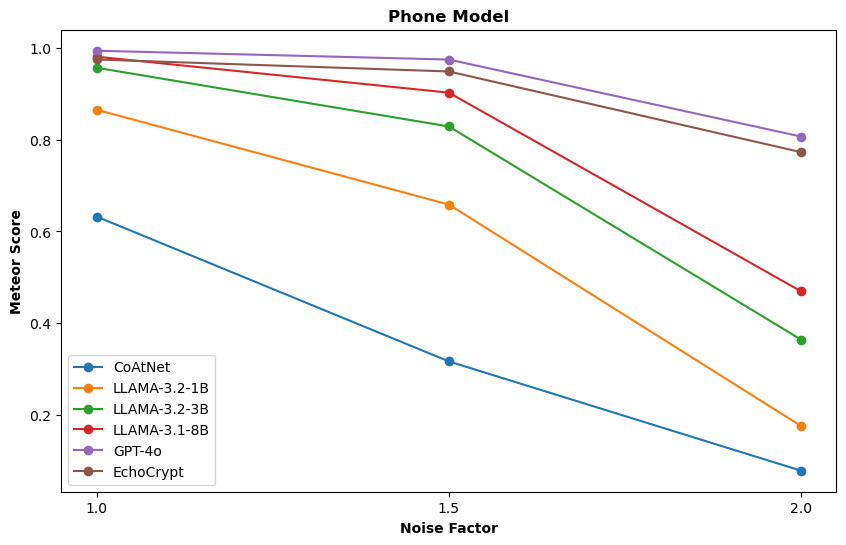

Base Model: Phone, Model: CoAtNet, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.68204983 0.39431874 0.13121548]
Base Model: Phone, Model: LLAMA-3.2-1B, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.87307422 0.68290491 0.22814519]
Base Model: Phone, Model: LLAMA-3.2-3B, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.95910411 0.84110145 0.42307913]
Base Model: Phone, Model: LLAMA-3.1-8B, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.98176666 0.90766286 0.51245752]
Base Model: Phone, Model: GPT-4o, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.99392301 0.97562185 0.81741384]
Base Model: Phone, Model: EchoCrypt, NF: ['1.0' '1.5' '2.0'], Rouge-1: [0.97569792 0.95043052 0.78636399]


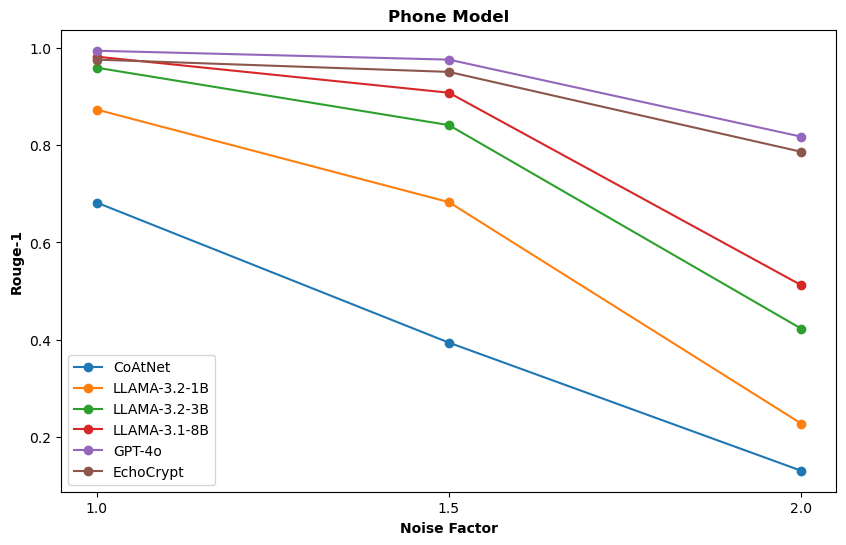

Base Model: Phone, Model: CoAtNet, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.48652941 0.1601762  0.01782547]
Base Model: Phone, Model: LLAMA-3.2-1B, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.80550456 0.52858694 0.08088121]
Base Model: Phone, Model: LLAMA-3.2-3B, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.92725602 0.73169597 0.20397929]
Base Model: Phone, Model: LLAMA-3.1-8B, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.96364219 0.83921926 0.29803383]
Base Model: Phone, Model: GPT-4o, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.98859123 0.95667665 0.70651018]
Base Model: Phone, Model: EchoCrypt, NF: ['1.0' '1.5' '2.0'], Rouge-2: [0.95325782 0.91164029 0.66099469]


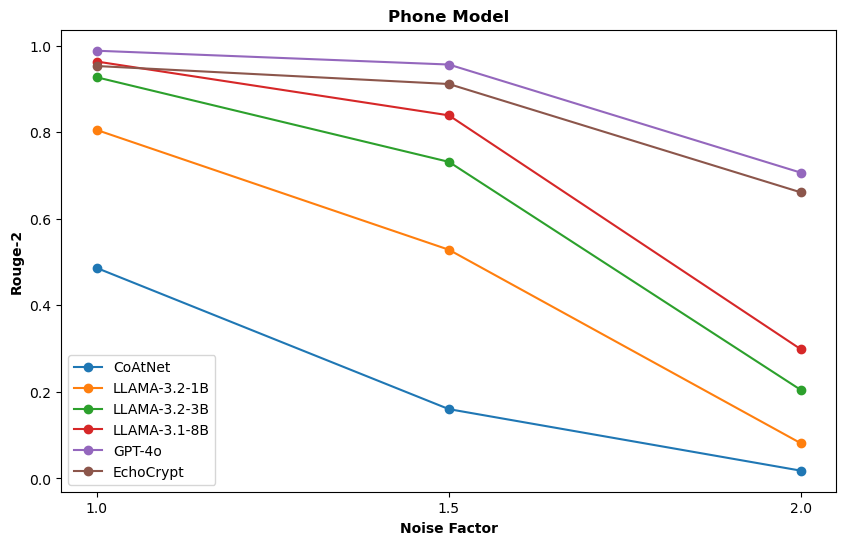

Base Model: Phone, Model: CoAtNet, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.68204983 0.39431874 0.13121548]
Base Model: Phone, Model: LLAMA-3.2-1B, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.87206392 0.68044568 0.22250766]
Base Model: Phone, Model: LLAMA-3.2-3B, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.95892783 0.84000325 0.41027838]
Base Model: Phone, Model: LLAMA-3.1-8B, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.98143934 0.90622666 0.50160343]
Base Model: Phone, Model: GPT-4o, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.99384609 0.97553094 0.81634191]
Base Model: Phone, Model: EchoCrypt, NF: ['1.0' '1.5' '2.0'], Rouge-L: [0.97569792 0.95035644 0.78452486]


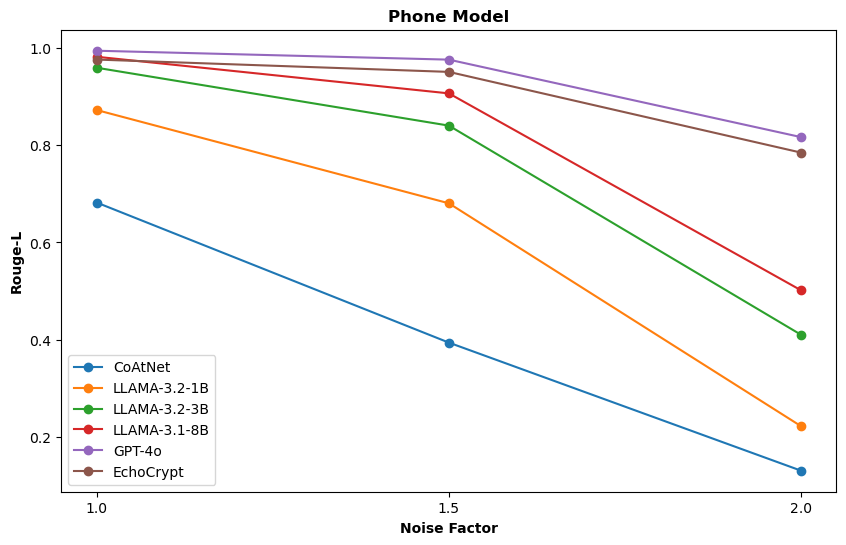

In [15]:
# Plot Levenshtein Accuracy
# plot_accuracy(results_df, 'Levenshtein Accuracy')

# Plot BLEU Accuracy
plot_accuracy(results_df, 'BLEU Accuracy')

# Plot Combined Accuracy
# plot_accuracy(results_df, 'Adjusted Accuracy')

# Plot Meteor Score
plot_accuracy(results_df, 'Meteor Score')

# Plot Rouge-1
plot_accuracy(results_df, 'Rouge-1')

# Plot Rouge-2
plot_accuracy(results_df, 'Rouge-2')

# Plot Rouge-L
plot_accuracy(results_df, 'Rouge-L')